<a href="https://colab.research.google.com/github/ds-joy/ML-Practice/blob/master/potato_leaf_diseases/potato_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# from google.colab import drive
# drive.mount('/content/drive')

In [68]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()

In [69]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

In [70]:
# ! kaggle datasets download -d arjuntejaswi/plant-village

In [71]:
# !mkdir potato

In [72]:
# !unzip plant-village.zip -d potato

In [73]:
# !rm -rf /content/potato/PlantVillage/Pepper__bell___Bacterial_spot/
# !rm -rf /content/potato/PlantVillage/Pepper__bell___healthy/

# !rm -rf /content/potato/PlantVillage/Tomato_Bacterial_spot/
# !rm -rf /content/potato/PlantVillage/Tomato_Early_blight/
# !rm -rf /content/potato/PlantVillage/Tomato_Late_blight/
# !rm -rf /content/potato/PlantVillage/Tomato_Leaf_Mold/
# !rm -rf /content/potato/PlantVillage/Tomato_Septoria_leaf_spot/
# !rm -rf /content/potato/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite/
# !rm -rf /content/potato/PlantVillage/Tomato__Target_Spot/
# !rm -rf /content/potato/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/
# !rm -rf /content/potato/PlantVillage/Tomato_healthy/
# !rm -rf /content/potato/PlantVillage/Tomato__Tomato_mosaic_virus/


In [74]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [75]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [76]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [77]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68


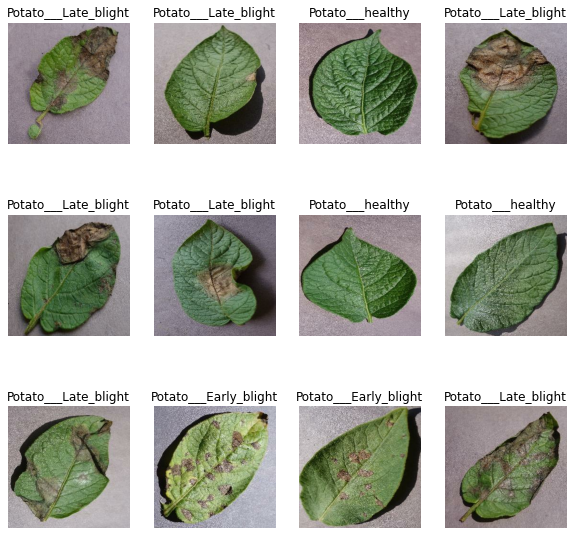

In [78]:
# for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(label_batch.numpy())
    # print("first image")
    # print(image_batch[0].shape)

    # visualization
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [79]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    


In [80]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [81]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [82]:
# runtime optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
# image preprocessing

# rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [84]:
#data_augmentation

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [85]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [86]:
# model training

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [87]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (32, 60, 60, 64)        

In [88]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
32/54 [================>.............] - ETA: 1:23 - loss: 0.9117 - accuracy: 0.4668